In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./loo_pft.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE


import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
mfile = '../../../checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)
data_path = '../../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape


df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
_, dfx = pretrainer.extract(dfcx, batch_size=16)
dfy = df_label.response_label

100%|##########| 71/71 [00:07<00:00,  9.09it/s]


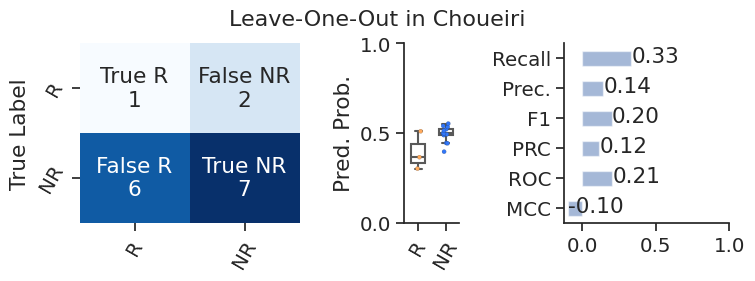

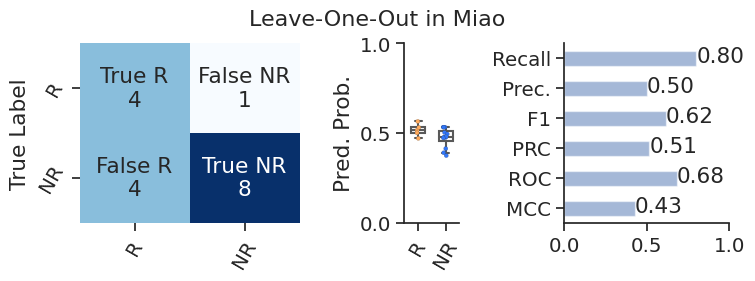

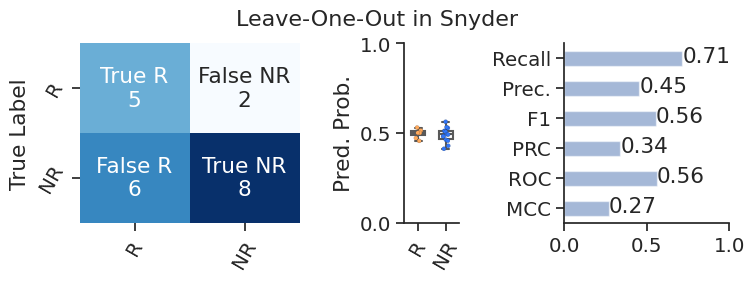

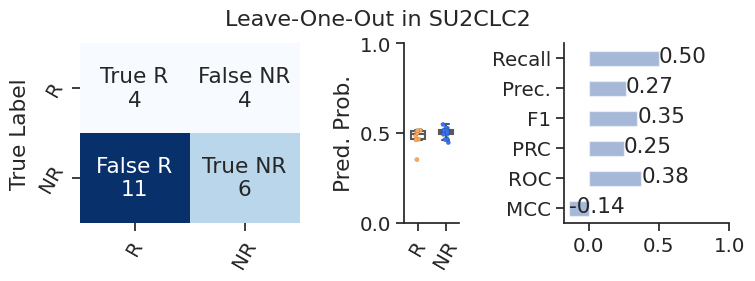

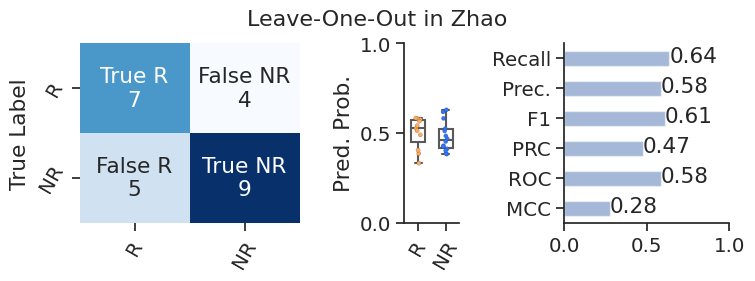

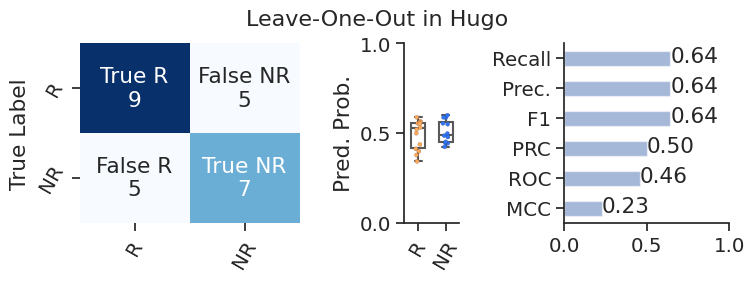

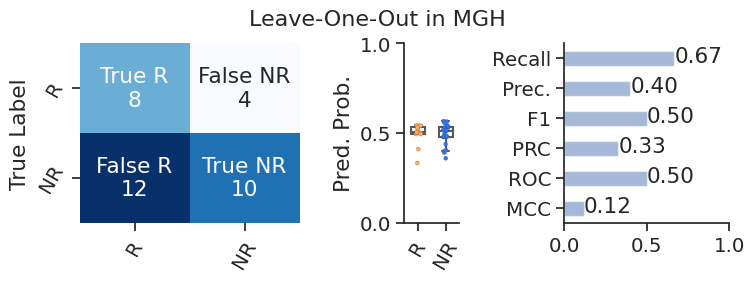

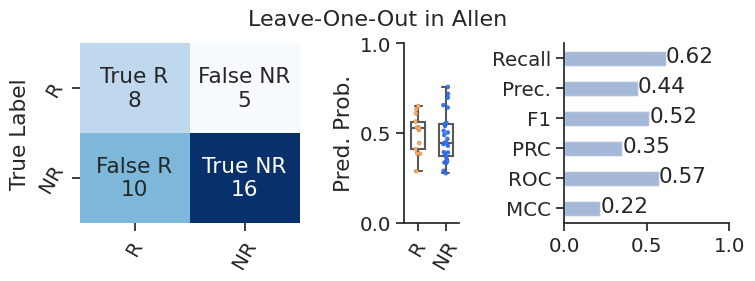

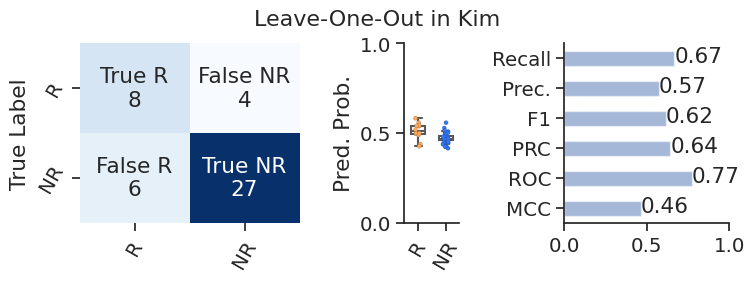

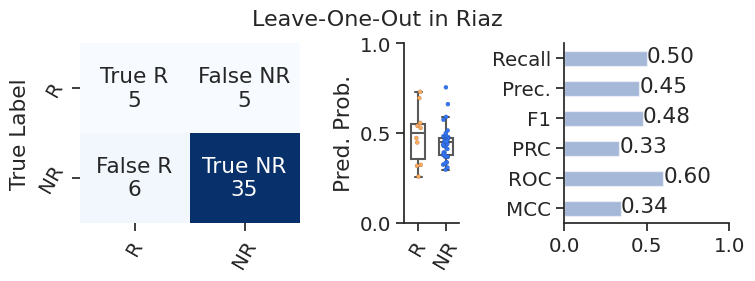

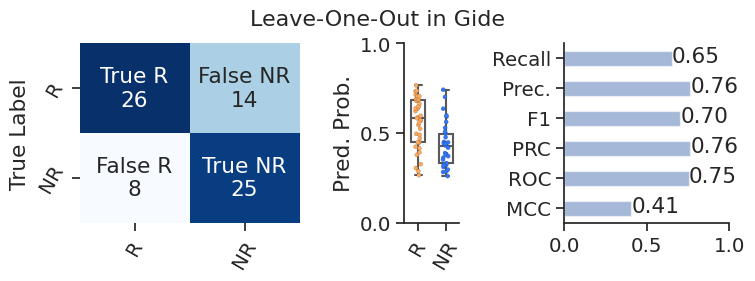

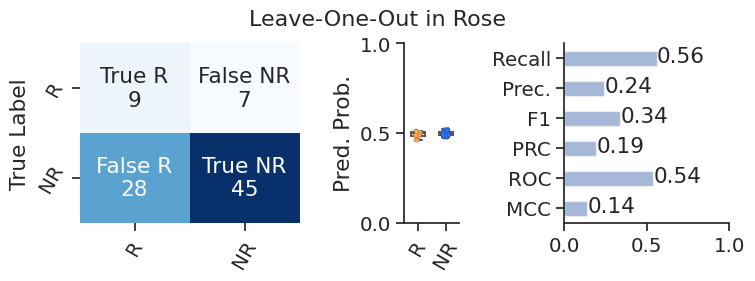

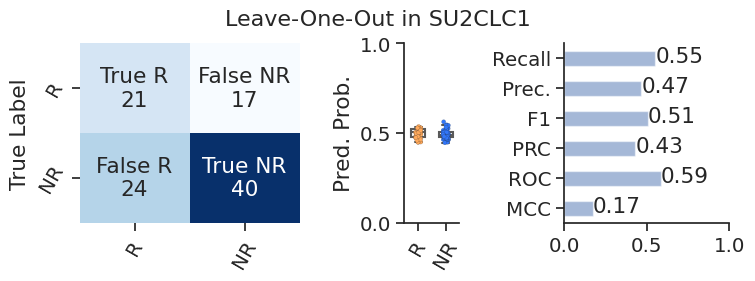

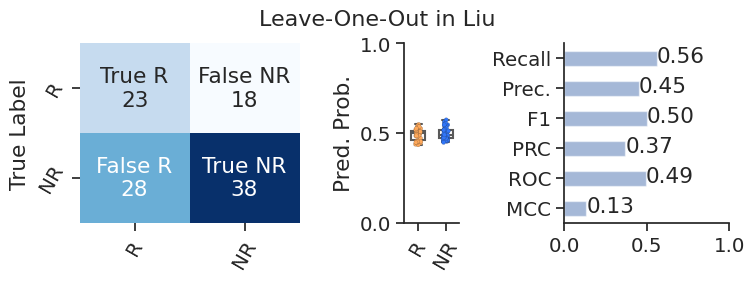

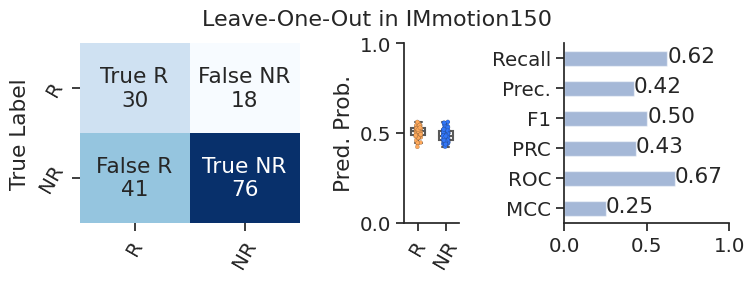

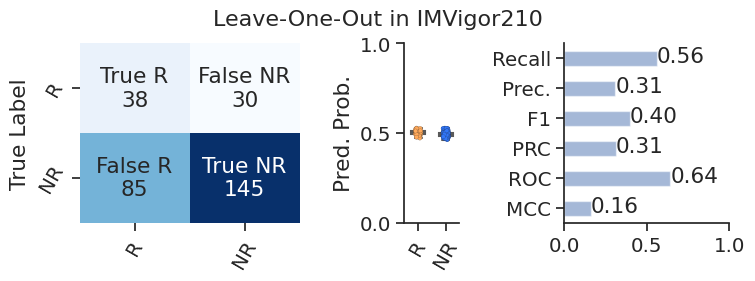

In [3]:
from conceptor.decoder import ProtoNetNFTDecoder

scols = dfx.columns
dfx_used = dfx[scols]

mode = 'NFT'
seed = 42
work_dir = './LOO_%s_%s' % (mode, seed)
if not os.path.exists(work_dir):
    os.makedirs(work_dir)


res = []
for cohort in cohorts:

    cohort_idx = df_label[df_label['cohort'] == cohort].index
    cohort_X = dfx_used.loc[cohort_idx]
    cohort_y = dfy.loc[cohort_idx]

    test_cohort_name = cohort

    predict_res = []
    for train_idx, test_idx in loo.split(cohort_idx):
        
        train_X = cohort_X.iloc[train_idx]
        train_y = cohort_y.iloc[train_idx]
        test_X = cohort_X.iloc[test_idx]    
        test_y = cohort_y.iloc[test_idx]
    
        support_set = train_X.join(train_y)
        query_set = test_X.join(test_y)
        
        NFT = ProtoNetNFTDecoder()
        NFT = NFT.fit(support_set)
        pred_testy = NFT.transform(query_set)


        pred_testy['cohort'] = test_cohort_name
        pred_testy['n_trainable_params'] = 0
        pred_testy['mode'] = mode
        pred_testy['seed'] = seed
        pred_testy['batch_size'] = np.nan
        pred_testy['task_dense_layer'] = np.nan
        predict_res.append(pred_testy)

    df_pred = pd.concat(predict_res)
    dfp = onehot(cohort_y.map({'PD':'NR', 'PR':'R',
                               'SD':'NR', 'CR':'R',
                               'NR':'NR', 'R':'R'})).join(df_pred)

    dfp.to_csv(os.path.join(work_dir, '%s.csv' % test_cohort_name ))
    
    y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
    s2 = score2(y_true, y_prob, y_pred)
    
    dfs = pd.DataFrame([s2], columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC'], index = ['Test'])
    dfs['cohort'] = test_cohort_name
    dfs['mode'] = mode
    dfs['seed'] = seed

    fig = plot_performance(y_true, y_prob, y_pred)
    fig.suptitle('Leave-One-Out in %s' % test_cohort_name, fontsize=16)
    fig.savefig(os.path.join(work_dir, 'leave_one_out_%s.jpg' % test_cohort_name))
    res.append(dfs)

dfres = pd.concat(res) #.reset_index(drop=True)
dfres.to_csv(os.path.join(work_dir, 'performance.tsv'), sep='\t')

In [4]:
dfres.MCC.mean() #0.21

0.21026066129091486

In [5]:
dfres.ACC.mean() #0.63

0.6198265660336173

In [6]:
dfres

,ROC,PRC,F1,ACC,MCC,cohort,mode,seed
Test,0.205128,0.115377,0.200000,0.500000,-0.100871,Choueiri,NFT,42
Test,0.683333,0.514341,0.615385,0.705882,0.426006,Miao,NFT,42
Test,0.561224,0.338800,0.555556,0.619048,0.269680,Snyder,NFT,42
Test,0.375000,0.249834,0.347826,0.400000,-0.140028,SU2CLC2,NFT,42
Test,0.584416,0.474979,0.608696,0.640000,0.277425,Zhao,NFT,42
Test,0.458333,0.499103,0.642857,0.615385,0.226190,Hugo,NFT,42
Test,0.500000,0.326342,0.500000,0.529412,0.117698,MGH,NFT,42
Test,0.573964,0.352186,0.516129,0.615385,0.218218,Allen,NFT,42
Test,0.772727,0.643330,0.615385,0.777778,0.463136,Kim,NFT,42
Test,0.600000,0.332472,0.476190,0.784314,0.341389,Riaz,NFT,42


In [7]:
dfres.head(6).ACC.mean() #0.63

0.5800524312289018

In [8]:
dfres.head(6).MCC.mean() #0.63

0.15973378658633744

In [9]:
dfres

,ROC,PRC,F1,ACC,MCC,cohort,mode,seed
Test,0.205128,0.115377,0.200000,0.500000,-0.100871,Choueiri,NFT,42
Test,0.683333,0.514341,0.615385,0.705882,0.426006,Miao,NFT,42
Test,0.561224,0.338800,0.555556,0.619048,0.269680,Snyder,NFT,42
Test,0.375000,0.249834,0.347826,0.400000,-0.140028,SU2CLC2,NFT,42
Test,0.584416,0.474979,0.608696,0.640000,0.277425,Zhao,NFT,42
Test,0.458333,0.499103,0.642857,0.615385,0.226190,Hugo,NFT,42
Test,0.500000,0.326342,0.500000,0.529412,0.117698,MGH,NFT,42
Test,0.573964,0.352186,0.516129,0.615385,0.218218,Allen,NFT,42
Test,0.772727,0.643330,0.615385,0.777778,0.463136,Kim,NFT,42
Test,0.600000,0.332472,0.476190,0.784314,0.341389,Riaz,NFT,42


In [10]:
df_label.cohort.value_counts()

cohort
IMVigor210     298
IMmotion150    165
Liu            107
SU2CLC1        102
Rose            89
Gide            73
Riaz            51
Kim             45
Allen           39
MGH             34
Hugo            26
Zhao            25
SU2CLC2         25
Snyder          21
Miao            17
Choueiri        16
Name: count, dtype: int64